<a href="https://colab.research.google.com/github/aaaronalexis/StockBot/blob/main/stockBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install customtkinter
#import customtkinter as ctk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

imput company ticker: AAPL
Enter a start date for historical data in YYYYMMDD or type "S" for the standard date setting of 2015,1,1 S
Enter a end date for historical data in YYYYMMDD or type "S" for the standard date setting of now S
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.466452   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.777185   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.779434   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.112867   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.039343   
...                ...         ...         ...         ...         ...   
2023-12-04  189.979996  190.050003  187.449997  189.429993  189.429993   
2023-12-05  190.210007  194.399

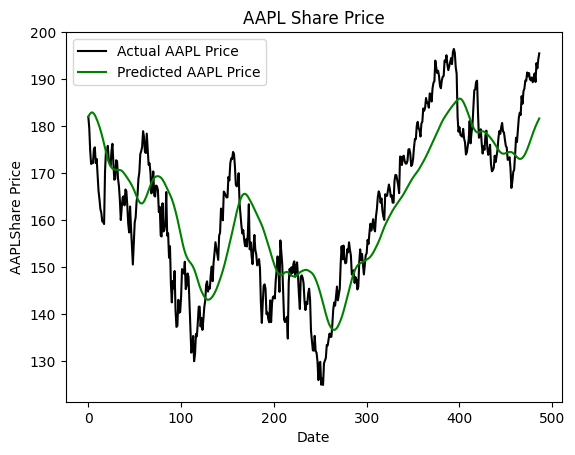

In [ ]:
# ctk.set_appearance_mode('dark')
# ctk.set_default_color_theme('dark-blue')

# root = ctk.CTk()
# root.geometry('500x350')

# frame = ctk.CTkFrame(master = root)
# frame.pack(pady=20, padx=60, fill='both', expand=True)

#using GUI to imput company ticker
# label = ctk.CTkLabel(master=frame, text='input company ticker: ', text_font=('Roboto', 24))
# label.pack(pady=12, padx = 10 )

# tckr = ctk.CTkEntry(master=frame, placeholder_text='Examples: AAPL, META, AMZN ...ect')

#imput company ticker
tckr = input('imput company ticker: ')
company = tckr

# #using GUI to imput company ticker
# label = ctk.CTkLabel(master=frame, text='Enter a start date for historical data in YYYYMMDD or type "S" for the standard date setting of 2015,1,1 ', text_font=('Roboto', 24))

#imput of start date and end data of historical data
inStart = input('Enter a start date for historical data in YYYYMMDD or type "S" for the standard date setting of 2015,1,1 ')
if (inStart == 'S'):
  start = dt.datetime(2015,1,1)
else :
  start = dt.datetime.strptime(inStart, '%Y%m%d')
inEnd = input('Enter a end date for historical data in YYYYMMDD or type "S" for the standard date setting of now ')
if (inStart == 'S'):
  end = dt.datetime.now()
else :
  end = dt.datetime.strptime(inEnd, '%Y%m%d')

#pulling historical data from the yfinance API
data = pdr.get_data_yahoo(company, start, end)

print(data)
YoN = input('Select Y or N if you want scaling range to depend on the defualt, Close. The other options are the columns in the data chart ')
if(YoN=='Y'):
  choose = input('Enter your choice: ')
else :
  choose = 'Close'
#scaling range from 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[choose].values.reshape(-1,1))

#setting amount of training data
prediction_days = int(input('Enter wanted amount of traing days. 60 days recommendation '))

#creating arrays for training data
x_train = []
y_train = []

#filling arrays in for training data
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])


#coverting to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#build model
model = Sequential()

#Making the layers with a dropout layers with backprop
YoN = input('Do you want to change the standard amounts of input layers and settings? "Y" or "N" ')
if (YoN=='Y'):
  HowMany = int(input('How many layers do you want for this model? Recommend 3. The more layers the bigger the brain. '))
  HowMany = HowMany - 1
  InpUnits = int(input('How many units do you want in this layer? Recommend 50. Too high might cause over fitting problems and will need more computing power. '))
  model.add(LSTM(units=InpUnits, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  InpUnits = float(input('Enter dropout rate. reccomended "0.2". The dropout rate indicates the fraction of input units that will be randomly set to 0 during training. This helps to prevent overfitting by introducing randomness and reducing the reliance on any one feature or neuron. '))
  model.add(Dropout(InpUnits))
  for n in range(HowMany) :
    InpUnits = int(input('How many units do you want in this layer? Recommend 50. Too high might cause over fitting problems and will need more computing power. '))
    model.add(LSTM(units=InpUnits, return_sequences=True))
    InpUnits = float(input('Enter dropout rate. reccomended "0.2". The dropout rate indicates the fraction of input units that will be randomly set to 0 during training. This helps to prevent overfitting by introducing randomness and reducing the reliance on any one feature or neuron. '))
    model.add(Dropout(InpUnits))

  InpUnits = int(input('How many units do you want in this layer? Recommend 50. Too high might cause over fitting problems and will need more computing power. '))
  model.add(LSTM(units=InpUnits))
  InpUnits = float(input('Enter dropout rate. reccomended "0.2". The dropout rate indicates the fraction of input units that will be randomly set to 0 during training. This helps to prevent overfitting by introducing randomness and reducing the reliance on any one feature or neuron. '))
  model.add(Dropout(InpUnits))
else:
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

#pritiction of the next price ********
model.add(Dense(units=1))

#adam or SGD optimizer
optmzr = input('enter adam or SGD optimizer ')
model.compile(optimizer= optmzr , loss='mean_squared_error')

#how many times the model see the data epoch. batch_size is at what size the model see the data
opt = int(input("enter epochs size. recommendation is 25 "))
opt2 = int(input("enter batch size recomendation is 32 "))
model.fit(x_train, y_train, epochs=opt, batch_size=opt2)

#test model on data that it has never seen before

test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(company, test_start, test_end)
actual_prices = test_data[choose].values

total_dataset = pd.concat((data[choose], test_data[choose]), axis=0)

model_input = total_dataset[len(total_dataset)- len(test_data)- prediction_days:].values
model_input = model_input.reshape(-1,1)
model_input= scaler.transform(model_input)


# make predictions on test data
x_test = []

for x in range(prediction_days, len(model_input)):
  x_test.append(model_input[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

#plot data

plt.plot(actual_prices, color= 'black', label=f"Actual {company} Price")
plt.plot(prediction_prices, color= 'green', label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Date')
plt.ylabel(f"{company}Share Price")
plt.legend()
plt.show()

#root.mainloop()

Y if you want to predict next day or N if you want to predict more then one day: N
how many days do you want to predict? 30
1/1 [==============================] - 0s 25ms/step
Do you want to plot the data or just a read out of numbers? "P" for plot. "N" for numbers. P


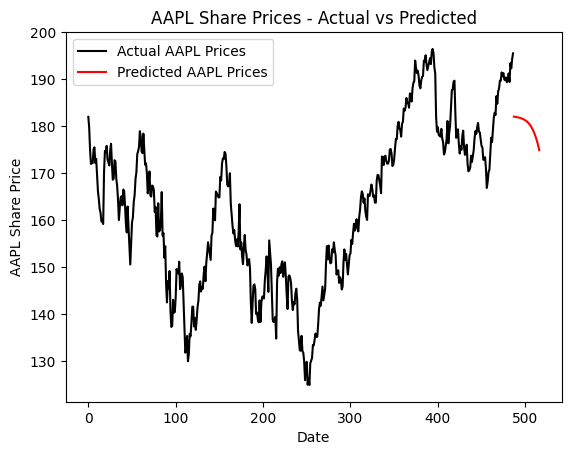

In [ ]:
#asking if they want next day prediction or how many day they want to predict.

YoN = input('Y if you want to predict next day or N if you want to predict more then one day: ')

#predict next day
if(YoN=='Y'):
  real_data = [model_input[len(model_input) + 1 - prediction_days:len(model_input+1), 0]]
  real_data = np.array(real_data)
  real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

  prediction = model.predict(real_data)
  prediction = scaler.inverse_transform(prediction)
  print(f"Prediction: {prediction}")

#predict any number of days
# Number of days to predict
else:
  NoD = int(input('how many days do you want to predict? '))
  num_days_to_predict = NoD

# List to store predictions for each day
  predictions = []

  for day in range(num_days_to_predict):
    # Prepare data for the next day
    next_day_data = [model_input[len(model_input) - prediction_days + day:len(model_input) + day, 0]]
    next_day_data = np.array(next_day_data)
    next_day_data = np.reshape(next_day_data, (next_day_data.shape[0], next_day_data.shape[1], 1))

    # Make prediction for the next day
    next_day_prediction = model.predict(next_day_data)
    next_day_prediction = scaler.inverse_transform(next_day_prediction)

    # Append the prediction to the list
    predictions.append(next_day_prediction[0, 0])

  PoN = input('Do you want to plot the data or just a read out of numbers? "P" for plot. "N" for numbers. ')
  if (PoN=='P'):
    plt.plot(actual_prices, color='black', label=f"Actual {company} Prices")
    x_extended = range(len(actual_prices), len(actual_prices) + num_days_to_predict)
    plt.plot(x_extended, predictions, color='red', label=f"Predicted {company} Prices")
    plt.title(f"{company} Share Prices - Actual vs Predicted")
    plt.xlabel('Date')
    plt.ylabel(f"{company} Share Price")
    plt.legend()
    plt.show()

  else:
    for day, prediction in enumerate(predictions, 1):
      print(f"Prediction for Day {day}: {prediction}")
